In [1]:
import sys
import climin
from functools import partial
import warnings
import os
sys.path.append('..')

import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.poisson import Poisson

from likelihoods.hetgaussian import HetGaussian

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.svmogp import SVMOGP
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams

warnings.filterwarnings("ignore")

from GPy.util.misc import safe_exp
from GPy import kern

from sklearn.cluster import KMeans

import random

In [2]:
r = 9
np.random.seed(r)
v_q = 1

# 2x2
# High resolution data
bins_h = np.linspace(0,500, 500, dtype=int)
bins_h = bins_h.reshape(250, 2)

for i in range(len(bins_h)):
    bins_h[i][0] = i+1
    bins_h[i][1] = i

X1_ = bins_h.copy()

res_no = 2
# Low resolution data
bins_l = np.linspace(0,250, 250, dtype=int)
bins_l = bins_l.reshape(125, 2)
for i in range(len(bins_l)):
    bins_l[i][0] = (i+1) * res_no
    bins_l[i][1] = i * res_no

X2_ = bins_l.copy()

X1 = np.zeros((X1_.shape[0], X1_.shape[1]+1))
X1[:,:-1] = X1_.copy()

X2 = np.zeros((X2_.shape[0], X2_.shape[1]+1))
X2[:,:-1] = X2_.copy()

X = [X1, X2]

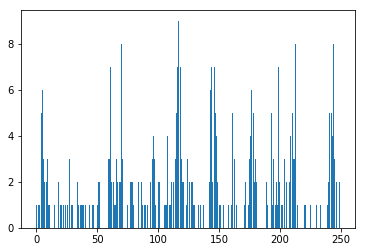

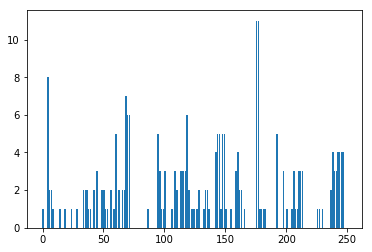

In [3]:
M = 100  # number of inducing points
Q = 1  # number of latent functions
l = 4.0
input_dim = 3

kern_extend = kern.Mix_Integral_extend(input_dim=input_dim, lengthscale=[l], variance=v_q, 
                                       name='Mix_Integral_extend') 

X_1_2_stack = np.vstack((X1,X2))
cov_xx_12 = kern_extend.K(X_1_2_stack)
N = X_1_2_stack.shape[0]
mean_xx_12 = np.zeros(N)

Y12 = np.random.multivariate_normal(mean=mean_xx_12, cov=cov_xx_12, size=1).T

ef12 = safe_exp(Y12)
samples12 = np.random.poisson(lam=ef12)

plt.figure()
plt.bar([i for i in range(len(samples12[:X1.shape[0]].reshape(-1,)))], samples12[:X1.shape[0]].reshape(-1,))

samples2_5dup = []
for i in samples12[X1.shape[0]:].reshape(-1,):
    for _ in range(res_no):
        samples2_5dup.append(i)

plt.figure()        
plt.bar([i for i in range(len(samples2_5dup))], samples2_5dup)

Y = [samples12[:X1.shape[0]], samples12[X1.shape[0]:]]

# Generating missing data (gap)
idx_low = 130
idx_up = 180
X1test = X[0][idx_low:idx_up]
Y1test = Y[0][idx_low:idx_up]

size = ((idx_up - idx_low))
idx = np.linspace(idx_low+1, idx_up, size)

X1_high_new = np.delete(X[0], idx, axis=0)
Y1_high_new = np.delete(Y[0], idx, axis=0)

X = [X1_high_new, X2]
Y = [Y1_high_new, samples12[X1.shape[0]:]]


In [4]:
# Heterogeneous Likelihood Definition
likelihoods_list = [Poisson(), Poisson()] 
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()
D = likelihood.num_output_functions(Y_metadata)

W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)

# KERNELS
ls_q = np.array(([l]*Q))
var_q = np.array(([v_q]*Q))
kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=input_dim)

#  Creating inducing inputs using cluster centers of the original images
X_ = np.vstack((X[0], X[1]))
kmeans_X = KMeans(n_clusters=M, random_state=0).fit(X_)
kmeans_X.cluster_centers_.shape
Z = kmeans_X.cluster_centers_
Z[:,-1] = 1

In [6]:
step_rate = 0.01
mode = "vem"

if mode == "adam":
    model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata, batch_size=150)
    model.Z.fix()
    print("which mode:\n", mode)
    max_iter = 400
    def callback(i):
        # global max_iter
        if i['n_iter'] % 50 ==0:
            print('svi - iteration '+ str(i['n_iter'])+'/' + str(int(max_iter)) + str(model.log_likelihood()))

        if i['n_iter'] > max_iter:
            return True
        return False

    opt = climin.Adam(model.optimizer_array, model.stochastic_grad, step_rate=step_rate, 
                decay_mom1=1 - 0.9, decay_mom2=1 - 0.999)
    opt.minimize_until(callback)

elif mode == "vem":        
    print("which mode:\n", mode)
    model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)
    model = VEM(model, vem_iters=10, maxIter_perVEM=100, optZ=False, verbose=False,verbose_plot=False,non_chained=True)
#     model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood,Y_metadata=Y_metadata, batch_size=50)
#     model = VEM(model, vem_iters=30, maxIter_perVEM=100, step_rate=step_rate, optZ=False, verbose=True, verbose_plot=False)
    model.kern_q0.variance.fix()

which mode:
 vem
iteration (1) VE step, log_likelihood=[-511.82018898]
iteration (1) VM step, log_likelihood=[-503.67617959]
iteration (2) VE step, log_likelihood=[-499.42445317]
iteration (2) VM step, log_likelihood=[-497.34360745]
iteration (3) VE step, log_likelihood=[-496.70851615]
iteration (3) VM step, log_likelihood=[-496.52569911]
iteration (4) VE step, log_likelihood=[-496.47460787]
iteration (4) VM step, log_likelihood=[-496.45533961]
iteration (5) VE step, log_likelihood=[-496.44388902]
iteration (5) VM step, log_likelihood=[-496.43481741]
iteration (6) VE step, log_likelihood=[-496.42650581]
iteration (6) VM step, log_likelihood=[-496.41882719]
iteration (7) VE step, log_likelihood=[-496.41148136]
iteration (7) VM step, log_likelihood=[-496.40457099]
iteration (8) VE step, log_likelihood=[-496.39795153]
iteration (8) VM step, log_likelihood=[-496.39171036]
iteration (9) VE step, log_likelihood=[-496.38574488]
iteration (9) VM step, log_likelihood=[-496.38016045]
iteration (

model:
 
Name : SVMOGP
Objective : 496.3697589730014
Number of Parameters : 5456
Number of Optimization Parameters : 3
Updates : True
Parameters:
  SVMOGP.              |               value  |  constraints  |  priors
  inducing_inputs      |            (100, 3)  |     fixed     |        
  m_u                  |            (100, 1)  |     fixed     |        
  L_u                  |           (5050, 1)  |     fixed     |        
  kern_q0.variance     |  0.6335378192925138  |   +ve fixed   |        
  kern_q0.lengthscale  |     3.6976064396593  |      +ve      |        
  B_q0.W               |              (2, 1)  |               |        
  B_q0.kappa           |                (2,)  |   +ve fixed   |        


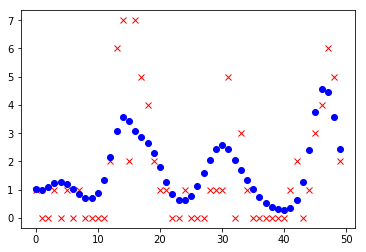

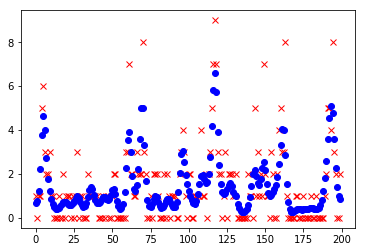

In [11]:
mu_pred, var_pred = model.predict(X1test)
posteriors = model.posteriors_F(X1test)
mu_fstar, var_fstar = posteriors[0].mean.copy(), np.diag(posteriors[0].covariance.copy())[:, None]

plt.figure()
# plt.title("Test")
plt.plot(Y1test, 'rx')

# plt.title("train")
plt.plot(mu_pred[0], 'bo')

mu_pred_train, var_pred_train = model.predict(X[0])
posteriors_ = model.posteriors_F(X[0])
mu_fstar_train, var_fstar_train = posteriors_[0].mean.copy(), np.diag(posteriors_[0].covariance.copy())[:, None]

plt.figure()
plt.plot(Y[0], 'rx')
plt.plot(mu_pred_train[0], 'bo')

# np.save('toy_data_gp_params.npy', model.param_array)
print("model:\n", model)

In [12]:
X1_train_slice1 = X[0][:131].copy()
Y1_train_slice1 = Y[0][:131].copy()
X1_train_slice2 = X[0][131:].copy()
Y1_train_slice2 = Y[0][131:].copy()

In [13]:
values = mu_pred[0].copy()
values = np.floor(values)

In [14]:
values_train = mu_pred_train[0].copy()
values_train = np.floor(values_train)

Text(0, 0.5, 'Count')

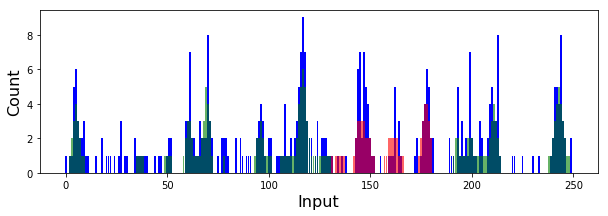

In [15]:
plt.figure(figsize=(10,3))
plt.bar([i for i in range(0, 131)], Y1_train_slice1.reshape((-1,)), color='b', width=0.9)
plt.bar([i for i in range(131, 181)], Y1test.reshape((-1,)), color='b', width=0.9)
plt.bar([i for i in range(181, 250)], Y1_train_slice2.reshape((-1,)), color='b', width=0.9)

plt.bar([i for i in range(0, 131)], values_train[:131].reshape((-1,)), color='g', width=0.9, alpha=0.6)
plt.bar([i for i in range(131, 181)], values.reshape((-1,)), color='r', width=0.9, alpha=0.6)
plt.bar([i for i in range(181, 250)], values_train[131:].reshape((-1,)), color='g', width=0.9, alpha=0.6)

plt.xlabel("Input", fontsize=16)
plt.ylabel("Count", fontsize=16)
